In [15]:
# Cell 0 — imports + reproducibility
import os, json, math, random, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from skimage.draw import polygon as sk_polygon
warnings.filterwarnings("ignore")

random.seed(42); np.random.seed(42)
print("✅ Base imports ready")


✅ Base imports ready


In [26]:
# Cell 1 — paths + config (EDIT HERE ONLY)

# KITTI "training" folder (where velodyne/, calib/, label_2/ live)
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")

# Output root and run id
OUT_ROOT = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")
RUN_ID   = 5  # just bump to 2,3,... when you want a new run folder

# BEV grid & ROI
cfg = dict(
    x_range=(0.0, 40.0),      # forward (m)
    y_range=(-20.0, 20.0),    # left/right (m)
    z_range=(-3.0, 1.0),      # vertical clip (m)
    H=256, W=256,             # raster size
    z_clip=2.0                # normalize HAG to [0..z_clip]
)

# categories we will label as foreground=1
KEEP = {"Car", "Van", "Truck", "Cyclist", "Pedestrian"}

# derive paths
VELO_DIR = DATA_ROOT / "velodyne"
LAB_DIR  = DATA_ROOT / "label_2"
CAL_DIR  = DATA_ROOT / "calib"

RUN_DIR  = OUT_ROOT / f"run_{RUN_ID}"
DS_DIR   = RUN_DIR / "dataset_3ch"          # where tiles will be stored
for sub in ("train","val"): (DS_DIR/sub).mkdir(parents=True, exist_ok=True)

ALL_FIDS = sorted(p.stem for p in VELO_DIR.glob("*.bin"))
print(f"Found frames: {len(ALL_FIDS)}")
print("Run dir:", RUN_DIR)


Found frames: 7481
Run dir: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_5


In [17]:
# Cell 2 — calib + label utilities + golden mask (labels→BEV)
import numpy as np

def read_calib(fid):
    """Return (R0_rect(3x3), T_v2c(3x4)) for a frame id."""
    R0_rect = None; Tr_velo_to_cam = None
    with open(CAL_DIR / f"{fid}.txt") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            k, v = ln.split(":", 1)
            arr = np.fromstring(v, sep=' ')
            if k == "R0_rect":        R0_rect = arr.reshape(3,3)
            if k == "Tr_velo_to_cam": Tr_velo_to_cam = arr.reshape(3,4)
    assert R0_rect is not None and Tr_velo_to_cam is not None, "Bad calib"
    return R0_rect, Tr_velo_to_cam

def inv_rt(R, t):
    """Inverse of [R|t]."""
    Rinv = R.T
    tinv = -Rinv @ t
    return Rinv, tinv

def cam_box_corners(h,w,l, x,y,z, ry):
    """
    KITTI: dimensions are height, width, length, location in camera rect coords,
    ry is yaw around camera Y-axis. Returns (8,3) corners in CAMERA rect coords.
    """
    # box in local cam frame, centered at (0,0,0) with KITTI's convention:
    # y is DOWN in camera rect, so bottom is at y=0, top at -h
    x_c = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ]
    y_c = [   0,    0,    0,    0,   -h,   -h,   -h,   -h ]
    z_c = [  w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2 ]
    pts = np.stack([x_c, y_c, z_c], axis=1).astype(np.float32)

    # rotate around Y (camera up axis in rectified coords is -Y in KITTI, but ry is around +Y)
    c, s = math.cos(ry), math.sin(ry)
    Ry = np.array([[ c, 0, s],
                   [ 0, 1, 0],
                   [-s, 0, c]], dtype=np.float32)
    pts = (Ry @ pts.T).T
    pts[:,0] += x; pts[:,1] += y; pts[:,2] += z
    return pts  # (8,3) in camera rect

def label_iter(fid, keep=None):
    """Yield (cls, h,w,l,x,y,z,ry) from label_2 file; filter by classes in KEEP if given."""
    keep = keep or KEEP
    with open(LAB_DIR / f"{fid}.txt") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            toks = ln.split()
            cls = toks[0]
            if cls not in keep: continue
            # fields per KITTI:
            # type, trunc, occl, alpha, bbox(4), h, w, l, x, y, z, ry
            h = float(toks[8]);  w = float(toks[9]);  l = float(toks[10])
            x = float(toks[11]); y = float(toks[12]); z = float(toks[13])
            ry = float(toks[14])
            yield cls, h,w,l,x,y,z,ry

def golden_mask_for_frame(fid, cfg, keep=None, dilate_px=0):
    """
    Rasterize BEV footprints (from labels) into a (H,W) uint8 mask (1=object).
    keep: set of class names to include; default KEEP.
    """
    x_range, y_range = cfg["x_range"], cfg["y_range"]
    H, W = cfg["H"], cfg["W"]
    sx = W / (x_range[1]-x_range[0])
    sy = H / (y_range[1]-y_range[0])

    g = np.zeros((H,W), np.uint8)

    R0, Tv = read_calib(fid)                    # R0_rect (3x3), Tr_velo_to_cam (3x4)
    Rc = Tv[:, :3]; tc = Tv[:, 3]
    # camera->velodyne inverse
    Rcv, tcv = inv_rt(Rc, tc)                   # (3x3), (3,)
    # rect->velo  :  v = Rcv * ( R0 * Xr ) + tcv
    M = Rcv @ R0                                # 3x3

    for cls,h,w,l,x,y,z,ry in label_iter(fid, keep=keep):
        P_cam = cam_box_corners(h,w,l,x,y,z,ry)         # (8,3) in camera rect
        P_velo = (M @ P_cam.T).T + tcv[None,:]          # (8,3) in velodyne
        # bottom four corners are indices [0..3] with our construction
        B = P_velo[:4, :2]  # x,y in velodyne
        # map to BEV pixels
        px = ( (B[:,0] - x_range[0]) * sx )
        py = ( (B[:,1] - y_range[0]) * sy )
        poly_x = np.clip(px, 0, W-1)
        poly_y = np.clip(py, 0, H-1)
        rr, cc = sk_polygon(poly_y, poly_x, shape=g.shape)
        g[rr,cc] = 1

    if dilate_px>0:
        from skimage.morphology import dilation, disk
        g = dilation(g, disk(dilate_px)).astype(np.uint8)
    return g


In [18]:
# Cell 3 — make 3-channel BEV from point cloud
def load_points_bin(fid):
    raw = np.fromfile(VELO_DIR / f"{fid}.bin", dtype=np.float32).reshape(-1,4)
    return raw[:, :3]  # x,y,z

def make_bev_channels_from_points(raw_xyz, cfg):
    x_range, y_range, z_range = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H, W = cfg["H"], cfg["W"]
    z_clip = cfg.get("z_clip", 2.0)

    x,y,z = raw_xyz.T
    m = (x>=x_range[0])&(x<=x_range[1])&(y>=y_range[0])&(y<=y_range[1])&(z>=z_range[0])&(z<=z_range[1])
    x,y,z = x[m], y[m], z[m]

    sx = W / (x_range[1]-x_range[0]); sy = H / (y_range[1]-y_range[0])
    ix = np.floor((x - x_range[0]) * sx).astype(np.int32)
    iy = np.floor((y - y_range[0]) * sy).astype(np.int32)
    m = (ix>=0)&(ix<W)&(iy>=0)&(iy<H)
    ix, iy, z = ix[m], iy[m], z[m]

    cnt  = np.zeros((H,W), np.int32)
    zmin = np.full((H,W),  1e6, np.float32)
    zmax = np.full((H,W), -1e6, np.float32)

    np.add.at(cnt, (iy, ix), 1)
    np.minimum.at(zmin, (iy, ix), z)
    np.maximum.at(zmax, (iy, ix), z)

    # column-wise ground estimate (robust)
    ground = np.full((W,), np.nan, np.float32)
    for j in range(W):
        col = zmin[:, j]
        mm  = (cnt[:, j] > 0) & np.isfinite(col)
        if mm.any():
            ground[j] = np.percentile(col[mm], 5.0)
    ground_map = np.tile(ground, (H,1))

    zmax_filled = np.where(cnt>0, zmax, ground_map)
    hag = np.clip(zmax_filled - ground_map, 0.0, z_clip) / max(z_clip,1e-6)

    occ = np.clip(cnt, 0, 255).astype(np.float32) / 255.0
    den = np.zeros_like(cnt, np.float32)
    if cnt.max() > 0: den = np.log1p(cnt) / np.log1p(cnt.max())

    X = np.stack([occ, hag.astype(np.float32), den.astype(np.float32)], axis=0)  # (3,H,W)
    return X
print("✅ BEV channel maker ready")


✅ BEV channel maker ready


In [19]:
# Cell 4 — build dataset from many frames (full-size tiles), split train/val

VAL_FRAC   = 0.10
MAX_FRAMES = None     # None = all frames; set e.g. 2000 for a quick run

fids = ALL_FIDS if MAX_FRAMES is None else ALL_FIDS[:MAX_FRAMES]
random.shuffle(fids)
cut = int(len(fids)*(1.0-VAL_FRAC))
split = {"train": fids[:cut], "val": fids[cut:]}
print({k:len(v) for k,v in split.items()})

def save_pair(root, name, X, g):
    root = Path(root); root.mkdir(parents=True, exist_ok=True)
    np.save(root / f"{name}_x.npy", X.astype(np.float32))
    np.save(root / f"{name}_y.npy", g.astype(np.uint8))

stats = {}
for part, ids in split.items():
    kept = 0
    for fid in tqdm(ids, desc=f"build {part}", unit="frame"):
        xyz = load_points_bin(fid)
        X   = make_bev_channels_from_points(xyz, cfg)    # (3,H,W)
        g   = golden_mask_for_frame(fid, cfg, keep=KEEP) # (H,W) 0/1
        save_pair(DS_DIR/part, f"{fid}_0000", X, g)
        kept += 1
    stats[part] = kept
print("built tiles:", stats, "| in_ch=3")


{'train': 6732, 'val': 749}


build val: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:55<00:00, 13.46frame/s]

built tiles: {'train': 6732, 'val': 749} | in_ch=3


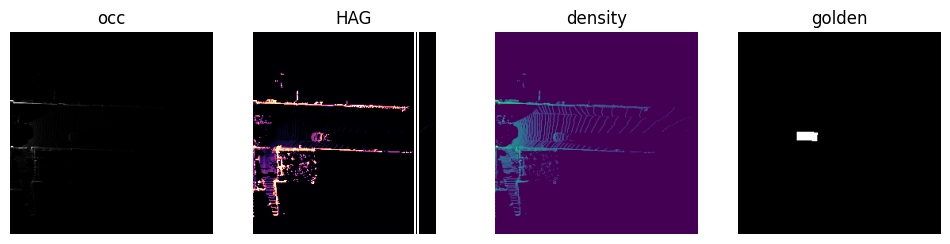

In [20]:
# Cell 5 — quick sanity plots on one frame in val
sample_val = sorted((DS_DIR/"val").glob("*_x.npy"))
assert sample_val, "No val tiles written?"
xp = sample_val[0]; yp = Path(str(xp).replace("_x.npy","_y.npy"))
X = np.load(xp); g = np.load(yp)
occ, hag, den = X

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].imshow(occ, cmap='gray', origin='lower'); ax[0].set_title("occ")
ax[1].imshow(hag, cmap='magma', origin='lower'); ax[1].set_title("HAG")
ax[2].imshow(den, cmap='viridis', origin='lower'); ax[2].set_title("density")
ax[3].imshow(g,   cmap='gray', origin='lower'); ax[3].set_title("golden")
for a in ax: a.axis('off')
plt.show()


In [21]:
# Cell 6 — PyTorch dataset + loaders
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NpyTiles(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [Path(str(p).replace("_x.npy","_y.npy")) for p in self.xs]
        assert len(self.xs)==len(self.ys)>0
        # estimate pos weight
        pos, tot = 0, 0
        scan = min(500, len(self.ys))
        for yp in self.ys[:scan]:
            y = np.load(yp).astype(np.uint8)
            pos += y.sum(); tot += y.size
        self.pos_weight = float((tot-pos)/max(pos,1))

    def __len__(self): return len(self.xs)
    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)           # (3,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)[None,:,:]   # (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y.astype(np.float32))

def make_loaders(batch=16):
    train_ds = NpyTiles(DS_DIR/"train")
    val_ds   = NpyTiles(DS_DIR/"val")

    # class balancing via per-sample weight (mean of pixel weights)
    # compute mean foreground rate per tile quickly
    w_pos, w_neg = 1.0, 1.0
    # derive w_pos from dataset-wide pos_weight
    w_pos = train_ds.pos_weight
    w_neg = 1.0

    weights = []
    for yp in train_ds.ys:
        y = np.load(yp).astype(np.uint8)
        p = y.mean()  # fraction of positive pixels
        w = p*w_pos + (1-p)*w_neg
        weights.append(max(w, 1e-6))

    sampler      = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=batch, sampler=sampler, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=0)
    return train_ds, val_ds, train_loader, val_loader

train_ds, val_ds, train_loader, val_loader = make_loaders(batch=16)
print(f"tiles: train={len(train_ds)}  val={len(val_ds)}  pos_weight≈{train_ds.pos_weight:.2f}")


tiles: train=6732  val=749  pos_weight≈72.48


In [23]:
# Cell 7a_New utility (place before your builder cell)
import numpy as np

def make_bev_channels_from_points(raw_xyz, cfg, H, W, z_clip=2.0, occ_scale=1.0):
    """
    Inputs:
      raw_xyz: float32 array (N,3) in LiDAR frame (x fwd, y left, z up).
      cfg: must have x_range, y_range, z_range
      H, W: BEV raster size
    Returns:
      X: float32 array (3, H, W) with channels:
         [0] occupancy (0..1), [1] height-above-ground normalized (0..1), [2] log-density (0..1)
    """
    x_range, y_range, z_range = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    x, y, z = raw_xyz.T

    # mask to ROI
    m = (x>=x_range[0])&(x<=x_range[1])&(y>=y_range[0])&(y<=y_range[1])&(z>=z_range[0])&(z<=z_range[1])
    x,y,z = x[m], y[m], z[m]

    # grid indices
    sx = W / (x_range[1]-x_range[0])
    sy = H / (y_range[1]-y_range[0])
    ix = np.floor((x - x_range[0]) * sx).astype(np.int32)
    iy = np.floor((y - y_range[0]) * sy).astype(np.int32)

    # keep in-bounds
    m = (ix>=0)&(ix<W)&(iy>=0)&(iy<H)
    ix, iy, z = ix[m], iy[m], z[m]

    # accumulators
    cnt  = np.zeros((H,W), np.int32)
    zmin = np.full((H,W),  1e6, np.float32)
    zmax = np.full((H,W), -1e6, np.float32)

    np.add.at(cnt, (iy, ix), 1)
    np.minimum.at(zmin, (iy, ix), z)
    np.maximum.at(zmax, (iy, ix), z)

    # column-wise ground estimate (robust 5th percentile of zmin per x-column)
    ground = np.full((W,), np.nan, np.float32)
    for j in range(W):
        col = zmin[:, j]
        mm  = (cnt[:, j] > 0) & np.isfinite(col)
        if mm.any():
            ground[j] = np.percentile(col[mm], 5.0)
    # broadcast to HxW
    ground_map = np.tile(ground, (H,1))

    # height-above-ground
    zmax_filled = np.where(cnt>0, zmax, ground_map)  # avoid NaNs where empty
    hag = np.clip(zmax_filled - ground_map, 0.0, z_clip) / max(z_clip, 1e-6)  # 0..1

    # occupancy (normalize 0..1; optional scaling)
    occ = np.clip(cnt * occ_scale, 0, 255).astype(np.float32) / 255.0

    # log-density (more dynamic range friendly)
    den = np.zeros_like(cnt, np.float32)
    if cnt.max() > 0:
        den = np.log1p(cnt) / np.log1p(cnt.max())

    X = np.stack([occ, hag.astype(np.float32), den.astype(np.float32)], axis=0)
    return X


In [28]:
# Cell 7 — Build a multi-frame dataset (train/val) with 3-channel BEV (occ, HAG, density)
import os, json, random
import numpy as np
from pathlib import Path
from tqdm import tqdm

random.seed(42); np.random.seed(42)

# —— paths (reuse your earlier definitions) ——
# DATA_ROOT must point to the KITTI "training" folder
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # edit if needed
VELO_DIR  = DATA_ROOT / "velodyne"
CAL_DIR   = DATA_ROOT / "calib"
LAB_DIR   = DATA_ROOT / "label_2"

# outputs
RUN_ROOT  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")
RUN_DIR   = RUN_ROOT / "run_5"
DS_DIR    = RUN_DIR / "dataset_balanced_3ch"
DS_DIR.mkdir(parents=True, exist_ok=True)
for sub in ["train", "val"]:
    (DS_DIR/sub).mkdir(parents=True, exist_ok=True)

# —— config (your ROI & raster) ——
cfg = {
    "x_range": (0.0, 40.0),
    "y_range": (-20.0, 20.0),
    "z_range": (-3.0, 1.0),
    "H": 256, "W": 256
}
KEEP = {"Car", "Van", "Truck", "Cyclist", "Pedestrian"}  # labels we keep

# make sure your golden-mask helpers are already defined (from your previous Cell “fix golden”)
#   golden_mask_for_frame(fid, cfg, keep=KEEP, dilate_px=0)

# choose frames: all, or cap for quick runs
ALL_FIDS = sorted(p.stem for p in VELO_DIR.glob("*.bin"))
MAX_FRAMES = None    # set to e.g. 1200 for quicker build; None = all available
FID_LIST = ALL_FIDS if MAX_FRAMES is None else ALL_FIDS[:MAX_FRAMES]

# split
VAL_FRAC = 0.10
random.shuffle(FID_LIST)
cut = int(len(FID_LIST)*(1.0-VAL_FRAC))
split = {"train": FID_LIST[:cut], "val": FID_LIST[cut:]}

def load_points_bin(fid):
    raw = np.fromfile(VELO_DIR / f"{fid}.bin", dtype=np.float32).reshape(-1,4)
    return raw[:, :3]  # x,y,z

# build
stats = {"train":0, "val":0}
for part, fids in split.items():
    out = DS_DIR / part
    kept = 0
    for fid in tqdm(fids, desc=f"build {part}", unit="frame"):
        xyz = load_points_bin(fid)
        X = make_bev_channels_from_points(xyz, cfg, cfg["H"], cfg["W"], z_clip=2.0, occ_scale=1.0)

        # golden mask from labels
        g = golden_mask_for_frame(fid, cfg, KEEP)  # (H,W) uint8 0/1

        # save one full-size tile per frame: names like 000123_0000_x.npy / _y.npy
        name = f"{fid}_0000"
        np.save(out / f"{name}_x.npy", X.astype(np.float32))
        np.save(out / f"{name}_y.npy", g.astype(np.uint8))
        kept += 1
    stats[part] = kept
print(f"kept tiles: train={stats['train']}  val={stats['val']}")
print(f"in_ch = 3  (occ, HAG, density)")


build val: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:59<00:00, 12.67frame/s]

kept tiles: train=6732  val=749
in_ch = 3  (occ, HAG, density)


In [30]:
# Cell 8 — Train tiny BEV segmenter (3-ch), robust file pairing

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np, random, os
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== dataset location (3-ch tiles you built in Cell 7b_3ch) ====
DS_DIR = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_5\dataset_balanced_3ch")

# ==== training hyperparams ====
IN_CH   = 3          # occ + hag + density
BATCH   = 16
EPOCHS  = 60
LR      = 1e-3

def _pair_y_path(xp: Path) -> Path:
    """
    Return the matching label path for an input tile path.
    Tries common patterns:
      *_x.npy -> *_y.npy   (preferred)
      *_x.npy -> *y.npy    (older buggy export)
      fallback variants if needed.
    """
    s = str(xp)
    cand1 = Path(s.replace("_x.npy", "_y.npy"))
    cand2 = Path(s.replace("_x.npy", "y.npy"))
    # very defensive fallbacks:
    cand3 = xp.with_name(xp.name.replace("_x.npy", "_y.npy"))
    cand4 = xp.with_name(xp.name.replace("_x.npy", "y.npy"))
    for c in (cand1, cand2, cand3, cand4):
        if c.exists():
            return c
    raise FileNotFoundError(
        f"No matching label for {xp}\nTried:\n  {cand1}\n  {cand2}\n  {cand3}\n  {cand4}"
    )

class NpyTiles(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        assert len(self.xs) > 0, f"No *_x.npy files in {self.root}"
        self.ys = [ _pair_y_path(p) for p in self.xs ]
        assert len(self.xs)==len(self.ys)

        # estimate pos_weight from a sample of masks
        pos, tot = 0, 0
        for yp in self.ys[:min(300, len(self.ys))]:
            y = np.load(yp).astype(np.uint8)  # (H,W) with {0,1}
            pos += y.sum()
            tot += y.size
        # weight ≈ negatives/positives; clamp minimum to 1.0
        self.pos_weight = float(max((tot - pos)/max(pos,1), 1.0))
        print(f"{self.root.name}: n={len(self.xs)}  pos_w≈{self.pos_weight:.2f}")

    def __len__(self): return len(self.xs)

    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)      # (C,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)        # (H,W)
        if x.ndim == 2: x = x[None,...]
        if y.ndim == 2: y = y[None,...]                 # -> (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y.astype(np.float32))

# build loaders (simple shuffle; class skew handled by pos_weight in loss)
train_ds = NpyTiles(DS_DIR/"train")
val_ds   = NpyTiles(DS_DIR/"val")
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)
print(f"tiles: train={len(train_ds)}  val={len(val_ds)}  in_ch={IN_CH}  pos_w={train_ds.pos_weight:.2f}")

# tiny U-Net-ish head
class TinyUNet(nn.Module):
    def __init__(self, in_ch=3, base=16):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base, base, 3, padding=1), nn.ReLU())
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU())
        self.p2 = nn.MaxPool2d(2)
        self.b  = nn.Sequential(nn.Conv2d(base*2, base*4, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*4, base*4, 3, padding=1), nn.ReLU())
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.ReLU())
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.ReLU())
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b);  d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)  # (B,1,H,W) logits

model = TinyUNet(in_ch=IN_CH).to(device)

bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ds.pos_weight], device=device))
opt = torch.optim.Adam(model.parameters(), lr=LR)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4, verbose=False)

def eval_iou(loader, thr=0.5):
    model.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            p = (torch.sigmoid(model(xb)) > thr).float()
            inter += (p*yb).sum().item()
            union += (p+yb - p*yb).sum().item()
    return 0.0 if union==0 else inter/union

best_iou, best_path = 0.0, DS_DIR.parent/"tiny_bev.pt"
for ep in range(1, EPOCHS+1):
    model.train(); tot=0; n=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30)
    i40 = eval_iou(val_loader, 0.40)
    i50 = eval_iou(val_loader, 0.50)
    sch.step(1.0 - i50)
    print(f"epoch {ep:02d} | train_loss {tot/n:.4f} | val IoU t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best_iou:
        best_iou = i50
        torch.save(model.state_dict(), best_path)
print("saved model to:", best_path)


train: n=6732  pos_w≈77.98
val: n=749  pos_w≈80.13
tiles: train=6732  val=749  in_ch=3  pos_w=77.98
epoch 01 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 02 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 03 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 04 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 05 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 06 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 07 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 08 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 09 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 10 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 11 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 12 | train_loss nan | val IoU t0.30:0.000 t0.40:0.000 t0.50:0.000
epoch 13 | train_loss nan | val IoU 

In [ ]:
# Cell 8b — pick best threshold on val set for your saved model
import torch, numpy as np
from pathlib import Path

thr_grid = np.linspace(0.2, 0.8, 25)  # finer sweep
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = TinyBEV(IN_CH).to(device)
m.load_state_dict(torch.load(RUN_DIR/"tiny_bev.pt", map_location=device))
m.eval()

def iou_logits_thr(logits, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits)>thr).float()
    inter = (p*target).sum()
    union = p.sum() + target.sum() - inter
    return ((inter+eps)/(union+eps)).item()

ious = []
with torch.no_grad():
    for thr in thr_grid:
        per = []
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            per.append(iou_logits_thr(m(xb), yb, thr=float(thr)))
        ious.append(np.mean(per) if per else 0.0)

best_thr = float(thr_grid[int(np.argmax(ious))])
best_iou = float(max(ious))
print(f"Best val IoU {best_iou:.3f} @ threshold {best_thr:.2f}")


In [ ]:
# Cell 8c — quick visualization
import matplotlib.pyplot as plt, random, torch, numpy as np
m.eval()
xb,yb = next(iter(val_loader))
i = random.randrange(xb.size(0))
with torch.no_grad():
    pr = torch.sigmoid(m(xb.to(device)))[i,0].cpu().numpy()
gt = yb[i,0].numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(pr, cmap='magma'); plt.title("pred prob"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(gt, cmap='gray');  plt.title("golden");    plt.axis('off')
plt.show()
